In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from scipy.signal import savgol_filter

from modes_func import *
from definition.defPrincipal import *

In [2]:
def adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        return ds
    

def addGrille(ds):
    # On récupère la liste des fichiers à ouvrir via le fichier liste 
    path = "../"
    gridname = path+'gigatl3_grid.nc'
    gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
    ds['hc'] = gd.hc
    ds['h'] = gd.h
    # ds['Vtransform'] = gd.Vtransform
    ds['sc_r'] = gd.sc_r
    ds['sc_w'] = gd.sc_w
    ds['Cs_r'] = gd.Cs_r
    ds['Cs_w'] = gd.Cs_w
    ds['angle'] = gd.angle
    ds['mask_rho'] = gd.mask_rho

    # On modifie des dimensions et des coordonnées, on crée la grille xgcm
    ds = adjust_grid(ds)
    L = ds.dims['x_rho']
    M = ds.dims['y_rho']
    N = ds.dims['s_rho']

    # On crée la grille xgcm
    ds = xgcm_grid(ds)
    grid = ds.attrs['xgcm-Grid']
    return ds, grid

    
def xgcm_grid(ds):
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [3]:
file_mean_4Y = '../bvfDATA/bvf_4Y_23_G3.nc'
ds_4Y = xr.open_dataset(file_mean_4Y)
ds_4Y

N = (ds_4Y.bvf.values)**(1/2)
z = ds_4Y.z.values




In [4]:
exp_mean_month = 'bvf_GIGATL3'
indir = '../bvfDATA/'
infile = indir+exp_mean_month+'.nc'
ds = xr.open_dataset(infile)
dsZeta = xr.open_dataset('../bvfDATA/zeta_GIGATL3.nc')
ds, grid = addGrille(ds)
dsZeta, grid = addGrille(dsZeta)
ds['Vtransform'] = 2
dsZeta = dsZeta.isel(time_counter = 0, x_rho = slice(0,None,2), y_rho = slice(0,None,2))
ds = ds.isel(time_counter = 0, x_rho = slice(0,None,2), y_rho = slice(0,None,2))


# Compute depth at rho point
z_m = get_z(ds,zeta=dsZeta['zeta'],hgrid='r').compute()
bvf=w2rho(ds.bvf,ds)
#plot slice latitude
yrho, xrho = findLatLonIndex(ds, -23.,0.)
bvf_mean_month=bvf.isel(x_rho = xrho, y_rho = yrho)
N = (bvf_mean_month.values)**(1/2)
z = z_m.isel(x_rho = xrho, y_rho = yrho).values

In [4]:
## Compute vertical eigenmodes

phi,lmbd,zz = SL_chebsolve((N), (z), Nmod="auto", Nz="auto", grav=9.80,sm=50, ksplin=3, zbot=None)

modes = phi[1]

eigval = np.real(lmbd)

for i in range(modes.shape[1]):
    modes[:,i]=norm_mode(modes[:,i],zz)


modes[:,0] = np.ones(modes[:,0].shape)

In [5]:
namevar='modes'
modeCDFm = xr.Dataset({namevar:(['wmod','umod'],modes)})
modeCDFm.to_netcdf('modes_G3_4Y.nc')

In [6]:
namevar='lamba'
modeCDF = xr.Dataset({namevar:(['lambda'],eigval)})
modeCDF.to_netcdf('lambda_G3_4Y.nc')

In [7]:
namevar='zz'
modeCDF = xr.Dataset({namevar:(['zz'],zz)})
modeCDF.to_netcdf('zz_3.nc')

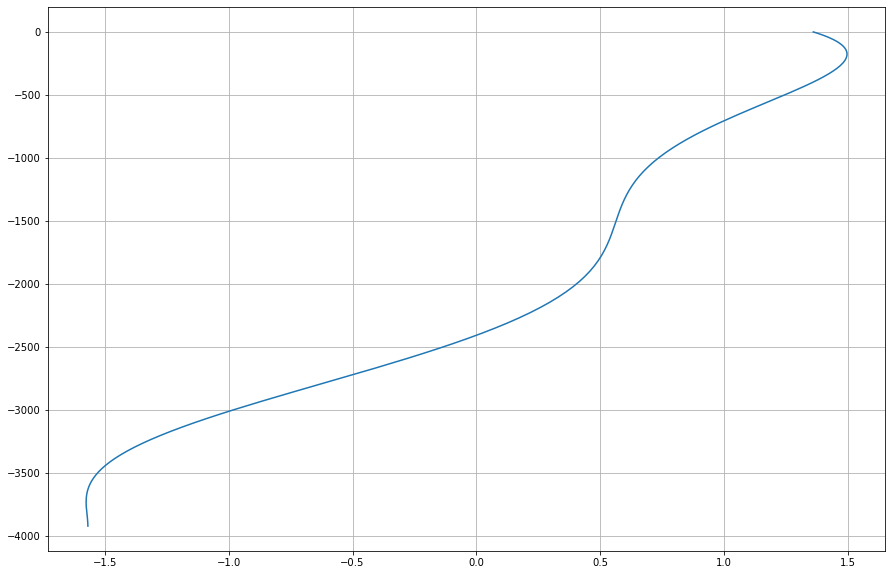

In [8]:
plt.figure(figsize=(15,10))
plt.plot(modes[:,1],(zz))
plt.grid()